In [30]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.datasets import OxfordIIITPet
import random
from torch.utils.data import random_split
from torchvision.models import resnet34
import torch.nn as nn

In [25]:
dataset = OxfordIIITPet("data", download=True, target_types="binary-category", split="trainval")

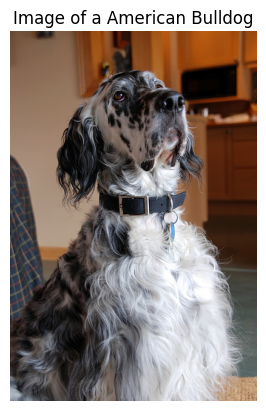

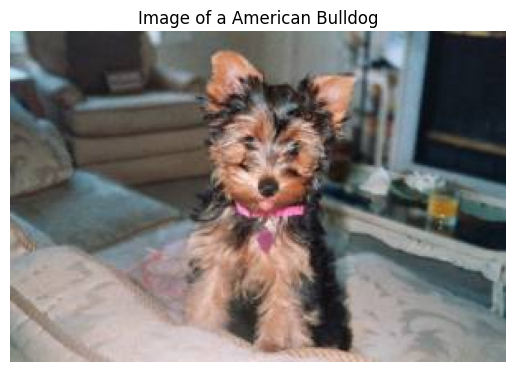

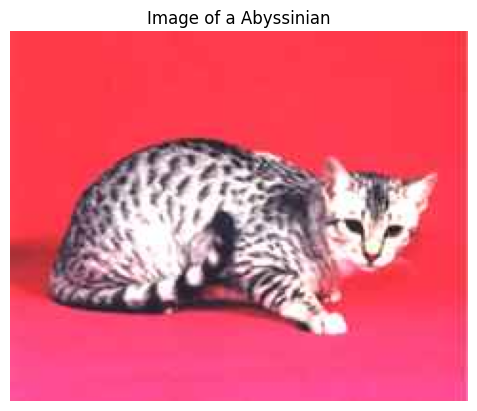

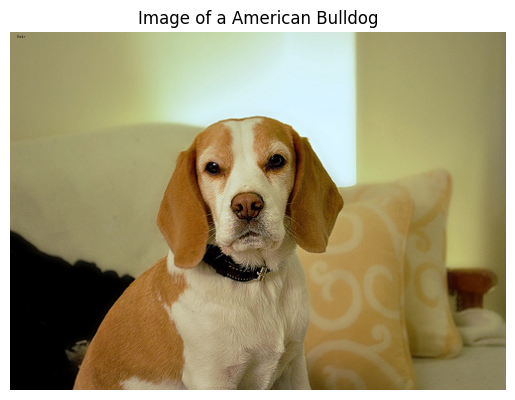

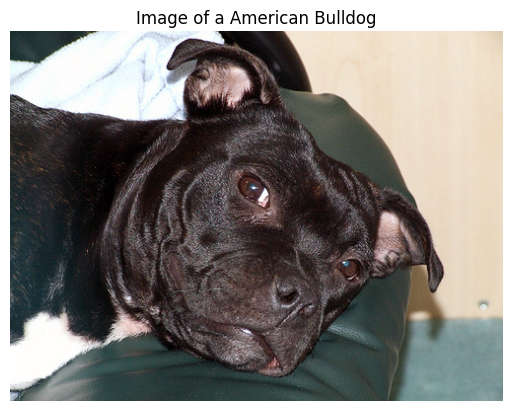

In [24]:
for i in range(5):
    image, label = dataset[random.choice(range(len(dataset)))]
    
    fig = plt.figure()
    plt.imshow(image)
    plt.title(f"Image of a {dataset.classes[label]}")
    plt.axis("off")

In [28]:
model = resnet34(weights="DEFAULT")
num_classes = 2

In [31]:
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [32]:
# Freeze all layers but the last one
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True